In [91]:
import torch 
import torchvision
from torch import nn 
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import transforms

import PIL

import matplotlib.pyplot as plt

from help_fn import accuracy_fn

In [92]:
print(f"""
    Python Version:
    Pytorch and Cuda Version: {torch.__version__}
    TorchVision and Cuda Version: {torchvision.__version__}
    PIL Version: {PIL.__version__}
""")


    Python Version:
    Pytorch and Cuda Version: 2.5.0+cu118
    TorchVision and Cuda Version: 0.20.0+cu118
    PIL Version: 11.0.0



In [93]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((.5,), (.5,))
])

In [ ]:
train_dataset = MNIST(root='./data',
                      transform=transform,
                      download=True,
                      train=True,
                      target_transform=None)

test_dataset = MNIST(root='./data',
                      transform=transform,
                      download=True,
                      train=False,
                      target_transform=None)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:01<00:00, 7.45MB/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 234kB/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 1.89MB/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 1.49MB/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



Image Shape: torch.Size([1, 28, 28])


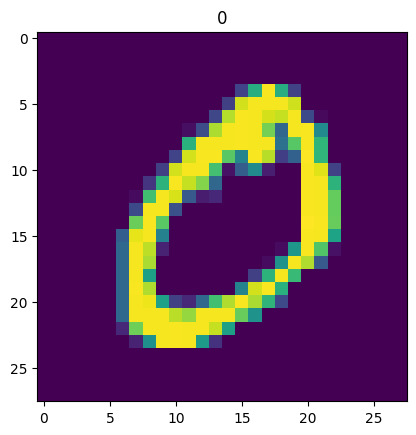

In [95]:
img, label = train_dataset[1]
print(f"Image Shape: {img.shape}")
plt.imshow(img.squeeze());
plt.title(label);

In [96]:
BATCH_SIZE = 32

train_dataLoader = DataLoader(train_dataset, 
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataLoader = DataLoader(test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

print(f"""
    Shape of train_dataloader: {len(train_dataLoader)} with batches of {BATCH_SIZE}
    Shape of test_dataloader: {len(test_dataLoader)} with batches of {BATCH_SIZE}
""")


    Shape of train_dataloader: 1875 with batches of 32
    Shape of test_dataloader: 313 with batches of 32



In [97]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [112]:
shape_img = img.shape[1]*img.shape[2]
in_ch = img.shape[0]
num_classes = len(train_dataLoader.dataset.class_to_idx)

### First DP Model (ANN)

In [120]:
class DigitDetectionModelV0(nn.Module):
    def __init__(self, inupt_shape:int,
                 output_shape:int):
        super().__init__()
        self.fc_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(inupt_shape, 16),
            nn.Linear(16, output_shape)
        )
    def forward(self, x):
        return self.fc_stack(x)

digitModel_v0 = DigitDetectionModelV0(shape_img, num_classes).to(device)
digitModel_v0

DigitDetectionModelV0(
  (fc_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=16, bias=True)
    (2): Linear(in_features=16, out_features=10, bias=True)
  )
)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(digitModel_v0.parameters(), .001)

In [122]:
from tqdm.auto import tqdm

# ========== Created train function ========== #
def train_model(model: nn.Module,
                dataloader: torch.utils.data.DataLoader,
                loss_fn: nn.Module,
                optimizer: torch.optim.Optimizer,
                accuracy_fn,
                epochs: int):
    for epoch in range(epochs):
        # ========== Initialized train mode ========== #
        print(f"=========================\nEpoch {epoch}")
        model.train()
        train_loss, train_acc = 0, 0

        for X_train, y_train in tqdm(dataloader):
            # Sended to GPU
            X_train, y_train = X_train.to(device), y_train.to(device)
            
            # 1. Started forward pass
            y_preds = model(X_train)

            # 2. Calculated loss
            loss = loss_fn(y_preds, y_train)
            train_loss += loss
            train_acc += accuracy_fn(y_train, torch.argmax(y_preds, 1))

            # 3. Optimizer zero grad
            optimizer.zero_grad()

            # 4. Backward
            loss.backward()

            # 5. Optimizer Step
            optimizer.step()

        train_loss /= len(dataloader)
        train_acc /= len(dataloader)
        
        print(f"Train Loss: {train_loss:.4f} | Accuracy: {train_acc:.2f}%")

In [ ]:
train_model(digitModel_v0, train_dataLoader, loss_fn, optimizer, accuracy_fn, 10)

Epoch 0


100%|██████████| 1875/1875 [00:22<00:00, 83.67it/s]


Train Loss: 0.5646 | Accuracy: 84.93%
Epoch 1


100%|██████████| 1875/1875 [00:23<00:00, 79.13it/s]


Train Loss: 0.3358 | Accuracy: 90.26%
Epoch 2


100%|██████████| 1875/1875 [00:22<00:00, 84.89it/s]

Train Loss: 0.3128 | Accuracy: 90.98%


In [126]:
def test_model(model: nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               accuracy_fn):
    model.eval()
    test_loss, test_acc = 0, 0

    for X_test, y_test in tqdm(dataloader):
        X_test, y_test = X_test.to(device), y_test.to(device)

        y_preds = model(X_test)

        test_loss += loss_fn(y_preds, y_test)
        test_acc += accuracy_fn(y_test, torch.argmax(y_preds,1))

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

    print(f"Test Loss: {test_loss:.4f} | Accuracy: {test_acc:.2f}%")

In [127]:
test_model(digitModel_v0, test_dataLoader, loss_fn, accuracy_fn)

100%|██████████| 313/313 [00:05<00:00, 56.63it/s]

Test Loss: 0.2999 | Accuracy: 91.41%
